## Imports

In [43]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import os
import sys

sys.path.append(os.path.abspath('..'))

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [44]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Generating Data

In [53]:
lower_in = 0
upper_in = 10
num_train = 40
noise = 0.6
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1)
y = f(x_train)

homoscedastic_noise = torch.randn_like(y) * noise**2
heteroscedastic_noise = torch.tensor(np.random.normal(loc=0, scale=x_train.detach().numpy()*noise**2))

x_train = x_train.to(torch.device('cuda')).to(torch.float64)
y_train = (y).to(torch.device('cuda')).to(torch.float64)

## Creating Gaussian Process

In [61]:
kernel_exp = RBFKernel(length_scale=1.0, amplitude=5.0).to(torch.device('cuda'))

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.0, max_iter=4_000, batch_size=num_train*2, lr=0.001, delta=1e-6)
gp_exp = gp_exp.fit(x_train, y_train)

print(gp_exp.noise)
print(gp_exp.kernel.get_params())

Iteration      0, Loss:     111.62
Iteration     50, Loss:     109.02
Iteration    100, Loss:     106.52
Iteration    150, Loss:     104.11
Iteration    200, Loss:     101.78
Iteration    250, Loss:      99.52
Iteration    300, Loss:      97.32
Iteration    350, Loss:      95.16
Iteration    400, Loss:      93.05
Iteration    450, Loss:      90.98
Iteration    500, Loss:      88.94
Iteration    550, Loss:      86.93
Iteration    600, Loss:      84.95
Iteration    650, Loss:      82.98
Iteration    700, Loss:      81.04
Iteration    750, Loss:      79.11
Iteration    800, Loss:      77.19
Iteration    850, Loss:      75.29
Iteration    900, Loss:      73.39
Iteration    950, Loss:      71.50
Iteration   1000, Loss:      69.61
Iteration   1050, Loss:      67.72
Iteration   1100, Loss:      65.84
Iteration   1150, Loss:      63.95
Iteration   1200, Loss:      62.06
Iteration   1250, Loss:      60.16
Iteration   1300, Loss:      58.26
Iteration   1350, Loss:      56.35
Iteration   1400, Lo

## Plotting GP Samples

torch.Size([30, 1500])


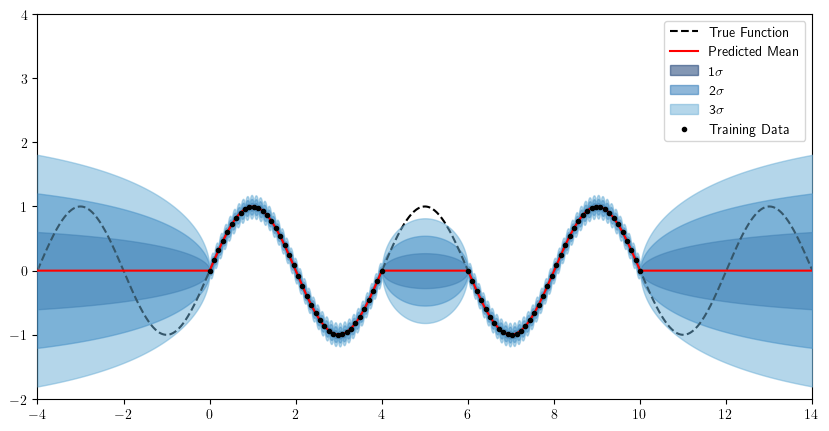

In [64]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()


cmap = plt.get_cmap('Blues')
colors = list(reversed([cmap(i) for i in np.linspace(0.5, 1, 3)]))
#fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_test = torch.linspace(-4, 14, 1500, device=torch.device('cuda')).unsqueeze(1)

y_pred, y_std = gp_exp.predict(x_test, return_std=True)
y_samples = gp_exp.predict(x_test, num_samples=30)

print(y_samples.shape)

#for i, sample in enumerate(y_samples):
#    ax0.plot(to_numpy(x_test), to_numpy(sample), c=colors[2], alpha=0.5, zorder=i*5)

#ax0.plot(to_numpy(x_test), to_numpy(y_samples[-1]), c=colors[2], alpha=0.5, label='Sampled Functions')

#ax0.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=175)
#ax0.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=160)
ax1.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=15)
ax1.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=20)




for i, color in zip([1,2,3], colors):
    upper = y_pred.squeeze() + i * y_std
    lower = y_pred.squeeze() - i * y_std

    ax1.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color=color, label= f"{i}" + r'$\sigma$', zorder=i*5)

#ax0.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=200)
ax1.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=25)

#ax0.set_xlim(-4, 14)
#ax0.set_ylim(-2, 4)
ax1.set_xlim(-4, 14)
ax1.set_ylim(-2, 4)

#ax0.legend()
ax1.legend()

plt.show()

## Coin Flip Example

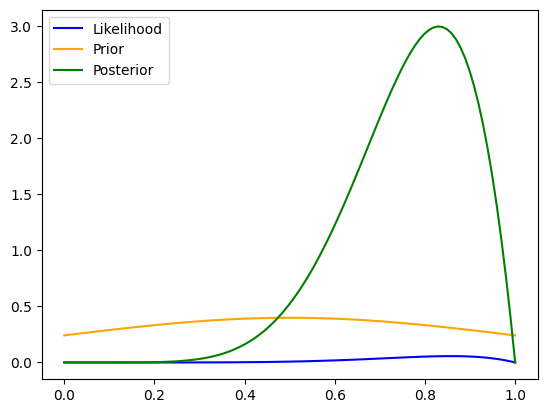

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def likeihood(p, D):
    a, b = D
    return p**a * (1 - p)**b

def prior(p):
    bounds = (0 <= p) & (p <= 1) 
    gaus_like = (1/np.sqrt(2*np.pi)) * np.exp(-(p - .5)**2/(2*.25))# Uniform prior over [0, 1]
    return gaus_like * bounds

def unif_posterior(p):
    return p**5

# Define the range of p values
D = (6,1)
p_values = np.linspace(0, 1, 100)
likelihood_values = likeihood(p_values, D)
prior_values = prior(p_values)
unnormalized_posterior_values = prior_values * likelihood_values
posterior_values = unnormalized_posterior_values / np.trapz(unnormalized_posterior_values, p_values)

plt.plot(p_values, likelihood_values, label='Likelihood', color='blue')
plt.plot(p_values, prior_values, label='Prior', color='orange')
plt.plot(p_values, posterior_values, label='Posterior', color='green')
plt.legend()
plt.show()

## Confidence vs Credible Intervals

Sample 37: 1.1032 ± 0.1004 does not contain the true mean 1.00
Sample 75: 1.1809 ± 0.1411 does not contain the true mean 1.00
Sample 77: 1.1796 ± 0.1683 does not contain the true mean 1.00
Sample 91: 0.8069 ± 0.1341 does not contain the true mean 1.00
Sample 104: 1.1877 ± 0.1802 does not contain the true mean 1.00
Sample 111: 1.1930 ± 0.1682 does not contain the true mean 1.00
Sample 113: 1.1417 ± 0.1191 does not contain the true mean 1.00
Sample 129: 0.8044 ± 0.1864 does not contain the true mean 1.00
Sample 168: 1.1704 ± 0.0673 does not contain the true mean 1.00
Sample 199: 0.8685 ± 0.1236 does not contain the true mean 1.00
Sample 258: 0.7922 ± 0.1406 does not contain the true mean 1.00
Sample 268: 1.1515 ± 0.1134 does not contain the true mean 1.00
Sample 294: 1.2028 ± 0.1870 does not contain the true mean 1.00
Sample 296: 0.8837 ± 0.1080 does not contain the true mean 1.00
Sample 325: 1.2131 ± 0.1998 does not contain the true mean 1.00
Sample 393: 1.1401 ± 0.1088 does not contain

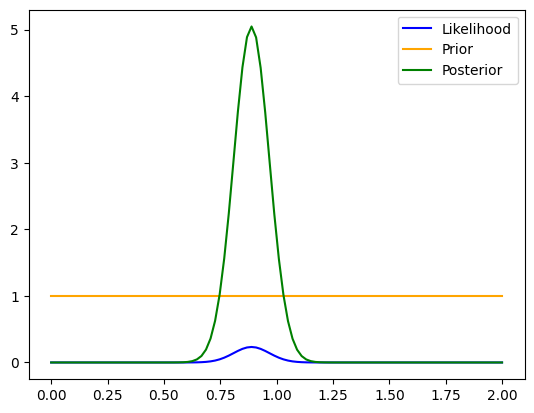

In [20]:
import numpy as np
import matplotlib.pyplot as plt

mu = 1
sigma = 0.25
sample_size = 10
c = 2.262  # for 95% confidence interval

num_samples = 10000

contains = 0

for i in range(num_samples):
    sample = np.random.normal(mu, sigma, sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)  # Sample standard deviation
    lower_bound = sample_mean - (c * sample_std / np.sqrt(sample_size))
    upper_bound = sample_mean + (c * sample_std / np.sqrt(sample_size))
    if lower_bound <= mu <= upper_bound:
        contains += 1
    else:
        print( f"Sample {i+1}: {sample_mean:.4f} ± {c * sample_std / np.sqrt(sample_size):.4f} does not contain the true mean {mu:.2f}")

print(f"{contains/num_samples:.2%} of the samples contained the true mean {mu:.2f} within the 95% confidence interval.")


def likelihood(samples, mu, sigma):
    samp_copy = samples.copy()

    prob = np.exp(-0.5 * ((samp_copy - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    return np.prod(prob)  # Return the product of probabilities for all samples

def prior(mu):
    # Assuming a uniform prior over mu in the range [0, 1]
    return 1.0 if 0 <= mu <= 2 else 0.0

mu_s = np.linspace(0, 2, 100)  # Range of mu values to evaluate
samples = np.random.normal(mu, sigma, sample_size)

likelihoods = np.array([likelihood(samples, mu_val, sigma) for mu_val in mu_s])
priors = np.array([prior(mu_val) for mu_val in mu_s])
# Normalize the likelihoods to avoid numerical issues
posterior = likelihoods * priors
posterior /= np.trapz(posterior, mu_s)  # Normalize the posterior distribution

plt.plot(mu_s, likelihoods, label='Likelihood', color='blue')
plt.plot(mu_s, priors, label='Prior', color='orange')
plt.plot(mu_s, posterior, label='Posterior', color='green')

plt.legend()
plt.show()